In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

workding_dir = str(Path.cwd().parent)
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

workding dir: /Users/inflaton/code/engd/papers/maritime/global-incidents
loading env vars from: /Users/inflaton/code/engd/papers/maritime/global-incidents/.env


True

In [2]:
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import contractions

import gensim
from gensim import corpora
from gensim import similarities
from gensim import models
from gensim.models import CoherenceModel

# from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import os
import glob
import json

import pickle
from datetime import datetime
import datetime

# Import Data

In [3]:
df = pd.read_csv("data/cleaned_data.csv")

# EDA

In [4]:
df.head()

id                                           Headline  \
0  1.0  Grasberg Mine- Grasberg mine workers extend st...   
1  2.0  Indonesia: Undersea internet cables damaged by...   
2  3.0  Shanghai port congestion impacts terminals in ...   
3  4.0  UPDATE - Indonesia: Explosion at KP Terminal i...   
4  5.0  UPDATE - Indonesia: Police confirm two explosi...   

                                             Details  Severity  \
0  Media sources indicate that workers at the Gra...  Moderate   
1  News sources are stating that recent typhoons ...     Minor   
2  The persisting port congestion at Shanghai’s Y...     Minor   
3  Updated local media sources from Jakarta indic...   Extreme   
4  According to local police in Jakarta, two expl...   Extreme   

                     Category     Region       Datetime    Year       lat  \
0         Mine Workers Strike  Indonesia  28/5/17 17:08  2017.0  -4.05608   
1              Travel Warning  Indonesia   4/9/17 14:30  2017.0       NaN   
2             Port Congestion      China   27/4/17 9:16  2017.0  29.52000   
3  Bombing, Police Operations  Indonesia  24/5/17 15:15  2017.0  -6.22465   
4  Bombing, Police Operations  Indonesia  24/5/17 16:20  2017.0       NaN   

         lon maritime_label                        found_ports  \
0  137.11302          False                       ['freeport']   
1        NaN          False                      ['hong kong']   
2  121.33190           True  ['ningbo', 'qingdao', 'shanghai']   
3  106.86700           True                        ['jakarta']   
4        NaN           True                        ['jakarta']   

   contains_port_info if_labeled  Month  Week  \
0                 1.0      False    5.0  21.0   
1                 1.0      False    4.0  14.0   
2                 1.0      False    4.0  17.0   
3                 1.0      False    5.0  21.0   
4                 1.0       True    5.0  21.0   

                                    Headline_Details  
0  Grasberg Mine- Grasberg mine workers extend st...  
1  Indonesia: Undersea internet cables damaged by...  
2  Shanghai port congestion impacts terminals in ...  
3  UPDATE - Indonesia: Explosion at KP Terminal i...  
4  UPDATE - Indonesia: Police confirm two explosi...

In [5]:
df.shape

(5782, 17)

In [6]:
df_copy = df.copy()

In [7]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5780 non-null   float64
 1   Headline            5780 non-null   object 
 2   Details             5780 non-null   object 
 3   Severity            5782 non-null   object 
 4   Category            5782 non-null   object 
 5   Region              5782 non-null   object 
 6   Datetime            5782 non-null   object 
 7   Year                5780 non-null   float64
 8   lat                 3881 non-null   float64
 9   lon                 3881 non-null   float64
 10  maritime_label      5780 non-null   object 
 11  found_ports         5778 non-null   object 
 12  contains_port_info  5778 non-null   float64
 13  if_labeled          5778 non-null   object 
 14  Month               5778 non-null   float64
 15  Week                5778 non-null   float64
 16  Headli

In [8]:
df_copy.isnull().sum()

id                       2
Headline                 2
Details                  2
Severity                 0
Category                 0
Region                   0
Datetime                 0
Year                     2
lat                   1901
lon                   1901
maritime_label           2
found_ports              4
contains_port_info       4
if_labeled               4
Month                    4
Week                     4
Headline_Details         4
dtype: int64

In [9]:
df_copy.dropna(subset=["Headline_Details"], inplace=True)

In [10]:
print("Published Date Statistics:")
print("Min Date:", df_copy["Datetime"].min())
print("Max Date:", df_copy["Datetime"].max())

Published Date Statistics:
Min Date: 1/1/20 11:07
Max Date: 9/9/20 6:54


In [11]:
# Check if there are any duplicated titles since a news can be published for multiple times by different publisher at different time
df_copy[["Year", "Headline_Details", "Region"]].duplicated().any()

False

In [12]:
# drop the duplicated news
duplicates = df_copy.duplicated(
    subset=["Year", "Headline_Details", "Region"], keep="first"
)
df_uni = df_copy[~duplicates]

In [13]:
df_uni.shape

(5778, 17)

# Text Preprocessing
contractions -> punctuation removal -> lowercase -> -> lemmanisation -> stop words removal + bigram

In [14]:
df_uni["Headline_Details"][5]

'UPDATE - Indonesia: Severe winds damage infrastructure in Bandung, West Java Severe winds have downed billboards and trees in Bandung on Wednesday afternoon. According to local media sources, the gales were accompanied by heavy rain which caused localised flooding in certain areas. Available images show a large billboard collapsed against the Flyover Rainbow Antapani causing significant congestion on Jalan Terusan Jakarta. There are no reports of casualties at this time. Travellers in Bandung should drive with caution and be prepared to alter routes at short notice. Keep abreast of the latest weather forecasts and defer journeys if necessary.'

In [15]:
## remove contractions, lowercase, remove numbers and punctuations, remove stopwords
# run time roughly 2 mins
df_uni["cleaned_Headline_Details"] = df_uni["Headline_Details"].apply(
    lambda x: [contractions.fix(word) for word in x.split()]
)

## convert back into string so that tokenization can be done
df_uni["cleaned_Headline_Details"] = [
    " ".join(map(str, l)) for l in df_uni["cleaned_Headline_Details"]
]

In [16]:
df_uni["cleaned_Headline_Details"][5]

'UPDATE - Indonesia: Severe winds damage infrastructure in Bandung, West Java Severe winds have downed billboards and trees in Bandung on Wednesday afternoon. According to local media sources, the gales were accompanied by heavy rain which caused localised flooding in certain areas. Available images show a large billboard collapsed against the Flyover Rainbow Antapani causing significant congestion on Jalan Terusan Jakarta. There are no reports of casualties at this time. Travellers in Bandung should drive with caution and be prepared to alter routes at short notice. Keep abreast of the latest weather forecasts and defer journeys if necessary.'

### Stemming / Lemmatization - To normalize text and prepare words.

https://towardsdatascience.com/stemming-vs-lemmatization-in-nlp-dea008600a0#:~:text=Stemming%20and%20Lemmatization%20are%20methods,be%20used%20in%20similar%20contexts.

Decided to use lemmatization because lemmatization provides better results by performing an analysis that depends on the word’s part-of-speech and producing real, dictionary words. As a result, lemmatization is harder to implement and slower compared to stemming.

To sum up, lemmatization is almost always a better choice from a qualitative point of view. With today’s computational resources, running lemmatization algorithms shouldn’t have a significant impact on the overall performance. However, if we are heavily optimizing for speed, a simpler stemming algorithm can be a possibility.

POS taggin + lemming for better lemming performance. However, the lemmatizer requires the correct POS tag to be accurate, 
if you use the default settings of the WordNetLemmatizer.lemmatize(), the default tag is noun.

https://github.com/nltk/nltk/blob/develop/nltk/stem/wordnet.py#L39 

In [17]:
# ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
# keep only ADJ, ADV, NOUN and VERB.

wnl = WordNetLemmatizer()


def lemmatize_words(text):
    # Tokenize the text into sentences and then words
    sentences = sent_tokenize(text)
    words = [word_tokenize(sentence) for sentence in sentences]

    # Remove punctuation and tokenize into lowercase words
    punc = [[w.lower() for w in word if re.search("^[a-zA-Z]+$", w)] for word in words]

    # Perform lemmatization on words with valid POS tags
    doc_lemmed = [
        wnl.lemmatize(word, pos[0].lower())
        for sentence in punc
        for word, pos in pos_tag(sentence, tagset="universal")
        if pos[0].lower() in ["a", "s", "r", "n", "v"]
    ]

    return doc_lemmed

In [18]:
%%capture
nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/inflaton/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/inflaton/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [19]:
%%time

df_uni["cleaned_Headline_Details"] = df_uni["cleaned_Headline_Details"].apply(
    lemmatize_words
)

CPU times: user 11.1 s, sys: 124 ms, total: 11.2 s
Wall time: 11.3 s


### N-gram + Stopword removal

In [20]:
stop_list = nltk.corpus.stopwords.words("english")
stop_list += ["local", "time", "wednesday", "source", "certain", "report", "update"]


def corpus2docs2(corpus):
    # corpus is a object returned by load_corpus that represents a corpus.
    docs = []
    for text in corpus:
        cleaned = [w for w in text if w not in stop_list]
        doc_pos = nltk.pos_tag(cleaned)
        phrases = []
        i = 0
        while i < len(doc_pos):
            if doc_pos[i][1] == "JJ":
                if (
                    i + 2 < len(doc_pos)
                    and doc_pos[i + 1][1] == "NN"
                    and doc_pos[i + 2][1] == "NN"
                ):
                    phrases.append(
                        (doc_pos[i][0], doc_pos[i + 1][0], doc_pos[i + 2][0])
                    )
                    i += 3
                elif i + 1 < len(doc_pos) and doc_pos[i + 1][1] == "NN":
                    phrases.append((doc_pos[i][0], doc_pos[i + 1][0]))
                    i += 2
                else:
                    i += 1
            elif doc_pos[i][1] == "NN":
                if (
                    i + 2 < len(doc_pos)
                    and doc_pos[i + 1][1] == "NN"
                    and doc_pos[i + 2][1] == "NN"
                ):
                    phrases.append(
                        (doc_pos[i][0], doc_pos[i + 1][0], doc_pos[i + 2][0])
                    )
                    i += 3
                elif i + 1 < len(doc_pos) and doc_pos[i + 1][1] == "NN":
                    phrases.append((doc_pos[i][0], doc_pos[i + 1][0]))
                    i += 2
                else:
                    i += 1
            else:
                i += 1
        phrase_set = ["_".join(word_set) for word_set in phrases]
        docs.append(phrase_set)
    return docs

In [21]:
print(stop_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [22]:
df_uni["binary_Headline_Details"] = corpus2docs2(df_uni["cleaned_Headline_Details"])

In [23]:
df_uni["binary_Headline_Details"][5]

['severe_wind_damage',
 'infrastructure_bandung',
 'severe_wind_billboard',
 'tree_bandung_afternoon',
 'accord_medium_gale',
 'heavy_rain_cause',
 'available_image_show',
 'large_billboard_collapse',
 'flyover_rainbow_antapani',
 'significant_congestion_jalan',
 'terusan_jakarta_casualty',
 'traveller_bandung_drive',
 'caution_prepare',
 'short_notice',
 'late_weather_forecast',
 'defer_journey']

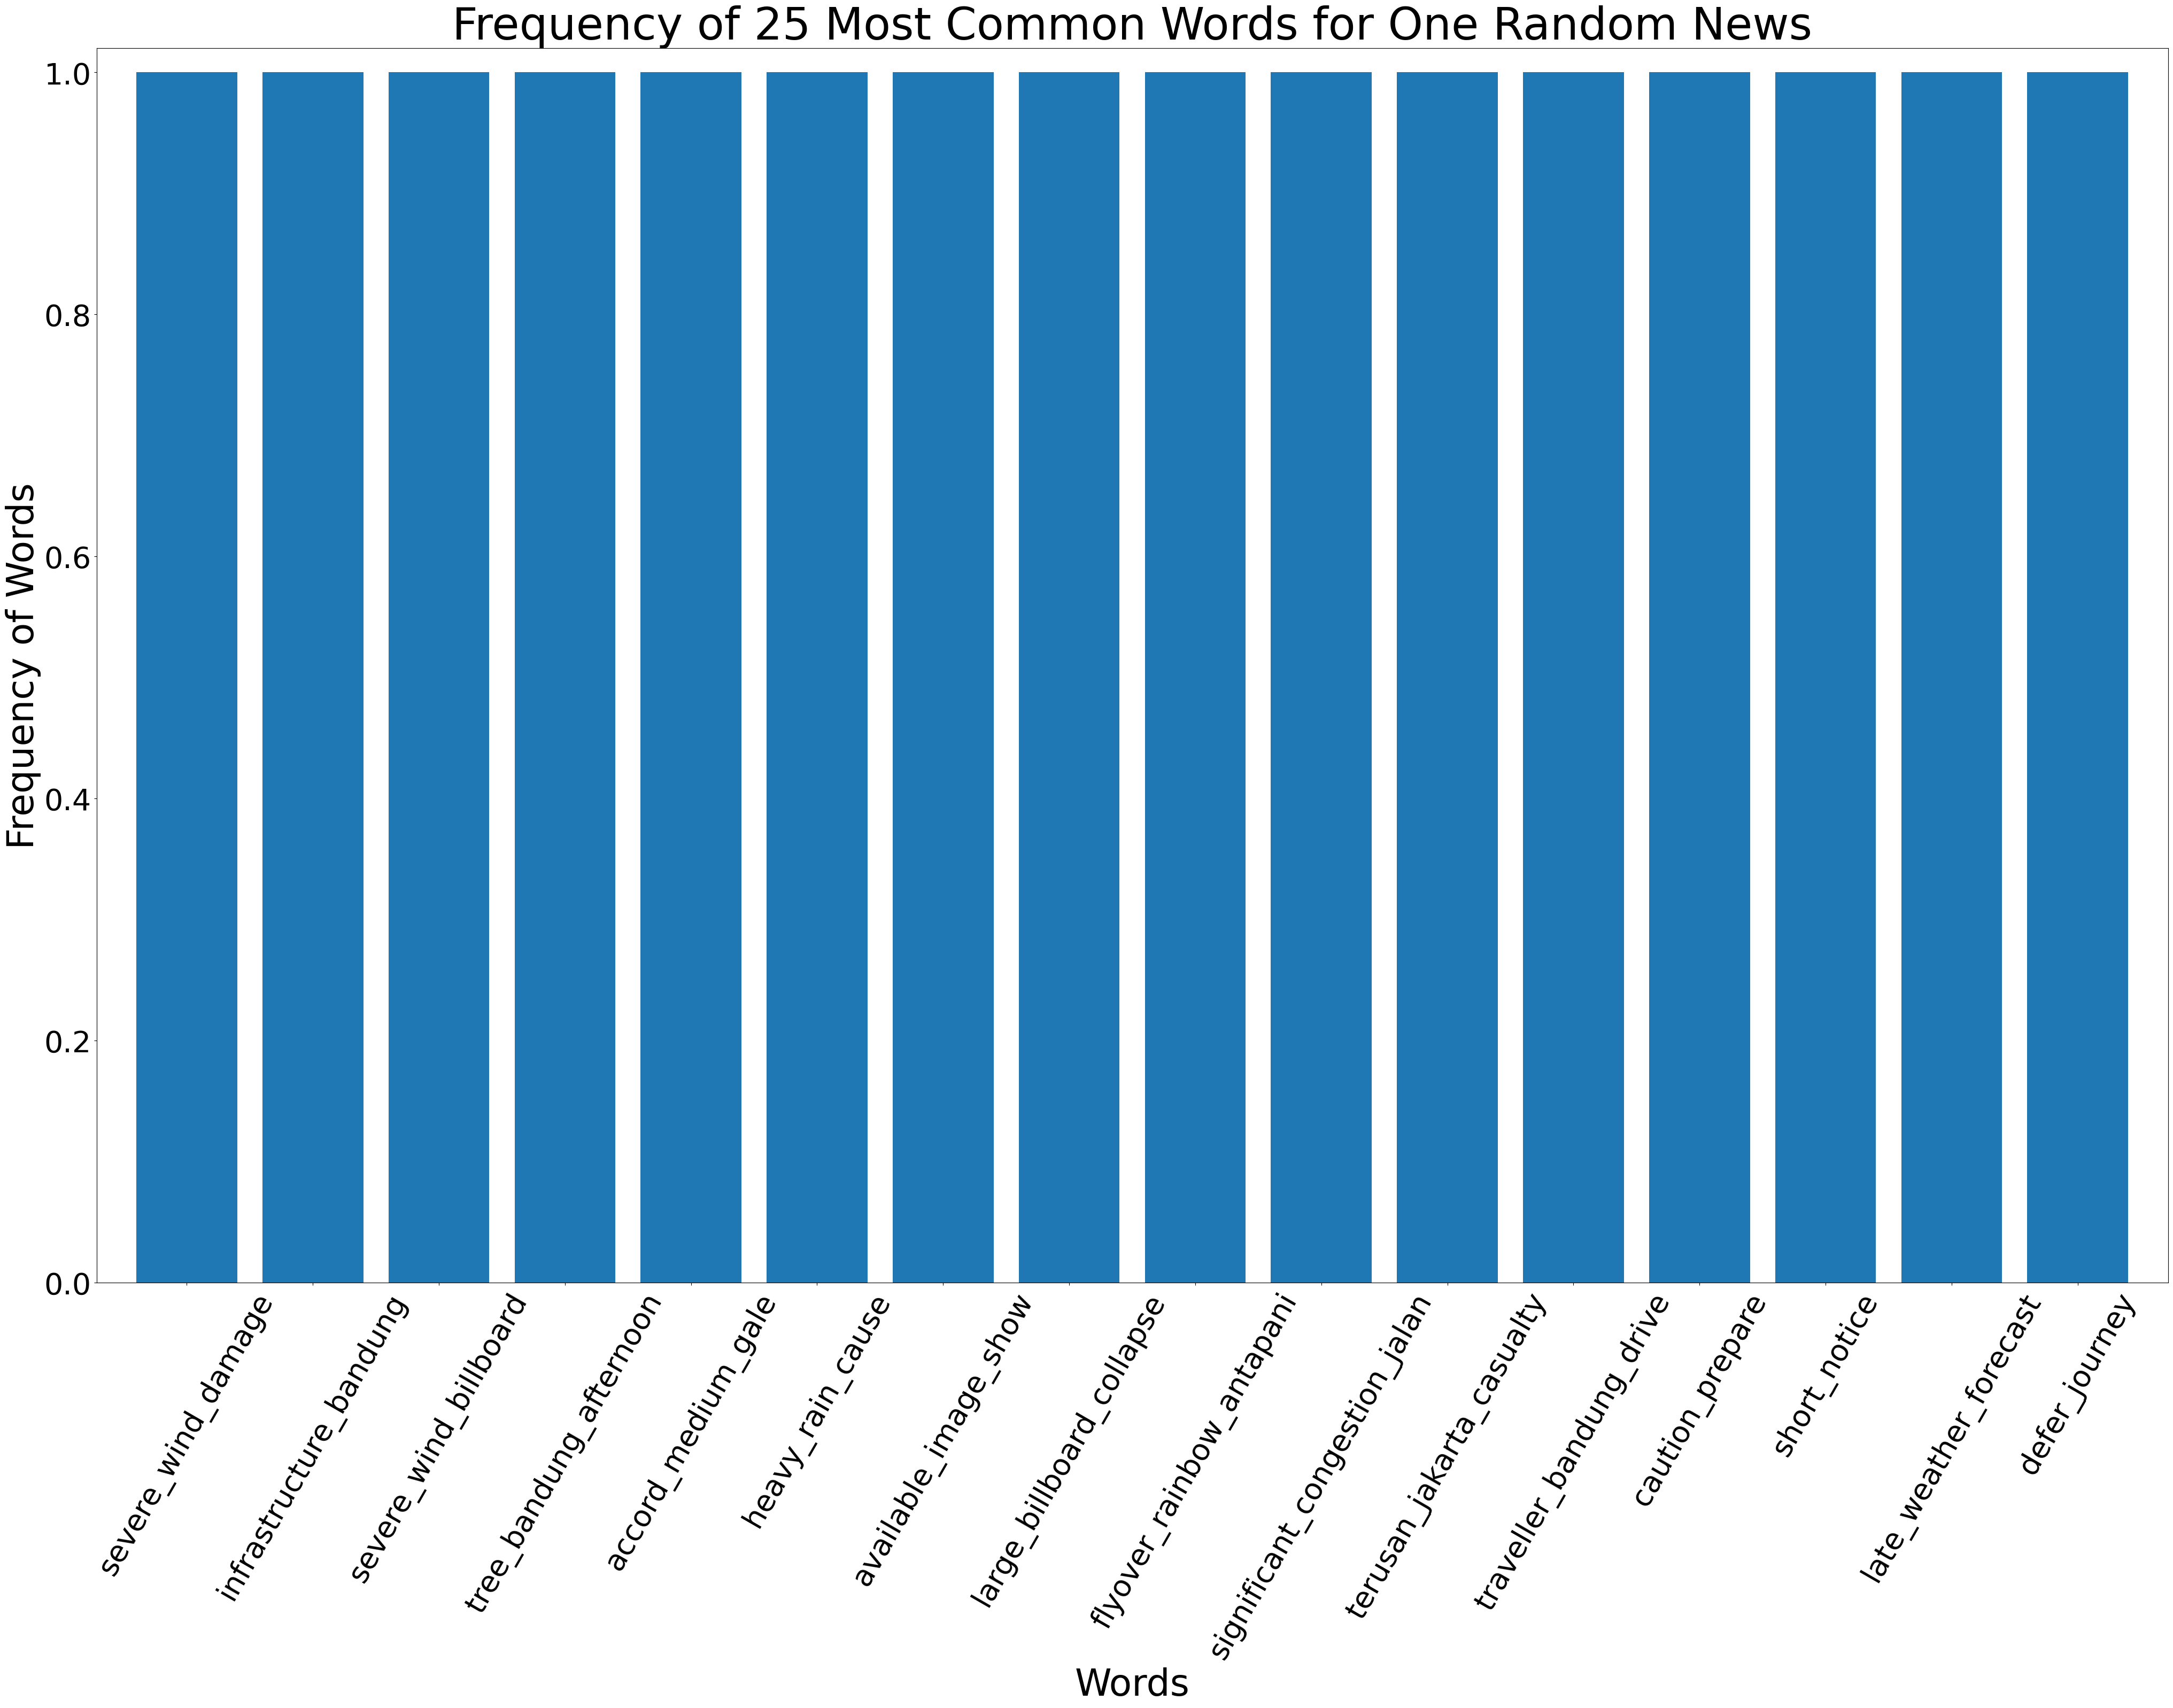

In [24]:
fdist_doc = nltk.FreqDist(df_uni["binary_Headline_Details"][5]).most_common(25)

x, y = zip(*fdist_doc)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title("Frequency of 25 Most Common Words for One Random News", fontsize=60)
plt.show()

In [25]:
all_words = [word for sublist in df_uni["binary_Headline_Details"] for word in sublist]
all_words[:2]
# Calculate word frequencies
fdist = FreqDist(all_words)

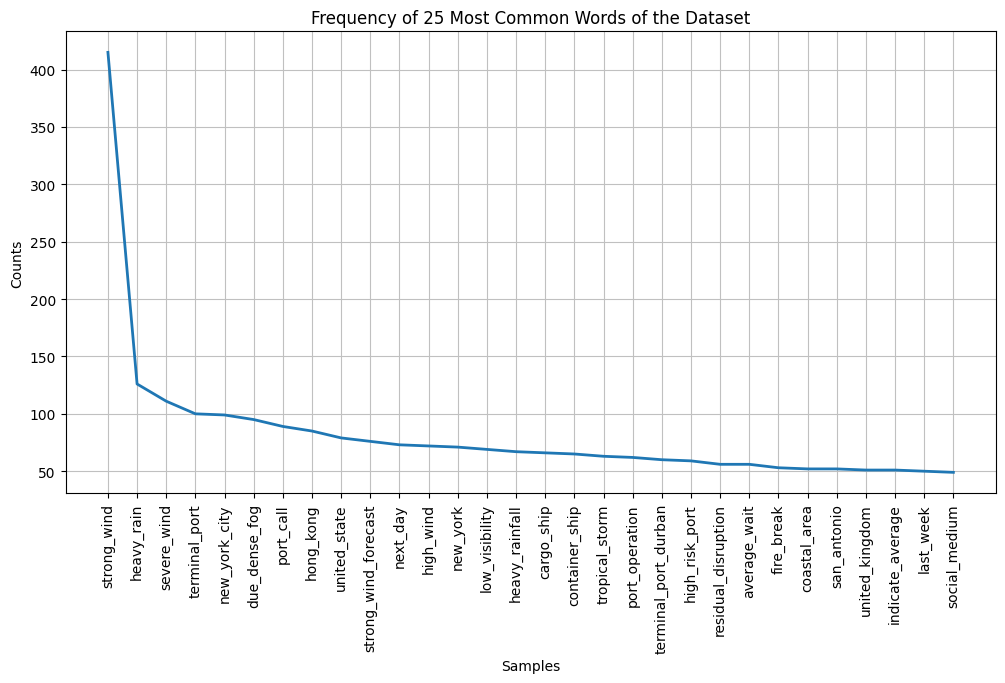

<Axes: title={'center': 'Frequency of 25 Most Common Words of the Dataset'}, xlabel='Samples', ylabel='Counts'>

In [26]:
# Plot the word frequency distribution as a bar graph
plt.figure(figsize=(12, 6))
plt.title("Frequency of 25 Most Common Words of the Dataset", fontsize=12)
fdist.plot(30, cumulative=False)

# Wordcloud

In [27]:
com = df_uni["Severity"].unique()
com[:10]

array(['Moderate', 'Minor', 'Extreme', 'Severe'], dtype=object)

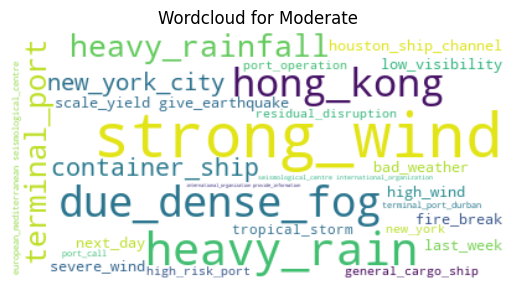

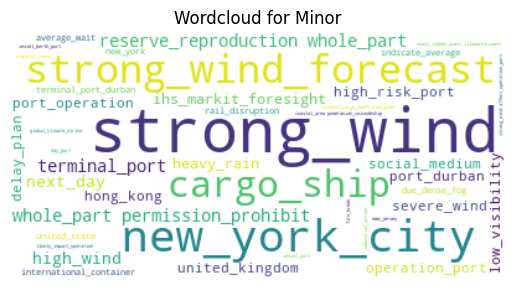

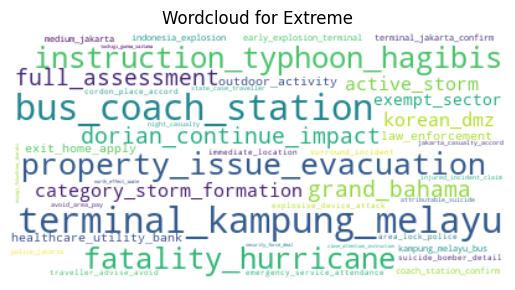

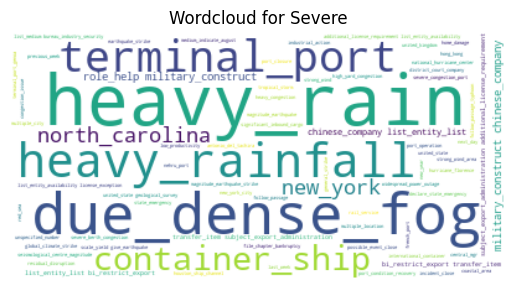

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Plotting with Seaborn for each company
for company in com[:10]:
    haha = df_uni["binary_Headline_Details"].loc[df_uni.Severity == company]
    text = " ".join(" ".join(item) for item in haha)
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Wordcloud for {company}")
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

## IT-IDF Word Removal

remove those frequently appeared but less important words like say, will, year, use, etc.

In [29]:
df_uni["binary_Headline_Details"] = df_uni["binary_Headline_Details"].apply(
    lambda x: " ".join(x)
)

# Tokenize the text and create a dictionary
documents = df_uni["binary_Headline_Details"].str.split()
dictionary = corpora.Dictionary(documents)

tfidf = models.TfidfModel(dictionary=dictionary, normalize=True)
tfidf_corpus = [tfidf[dictionary.doc2bow(doc)] for doc in documents]
term_frequencies = {dictionary[id]: freq for id, freq in tfidf.dfs.items()}

In [30]:
sorted_term_frequencies = dict(
    sorted(term_frequencies.items(), key=lambda item: item[1], reverse=True)
)
sorted_term_frequencies

{'strong_wind': 313,
 'terminal_port': 90,
 'port_call': 89,
 'heavy_rain': 88,
 'severe_wind': 77,
 'due_dense_fog': 72,
 'next_day': 71,
 'united_state': 68,
 'hong_kong': 68,
 'strong_wind_forecast': 68,
 'cargo_ship': 61,
 'high_wind': 60,
 'port_operation': 59,
 'new_york_city': 59,
 'heavy_rainfall': 58,
 'container_ship': 57,
 'residual_disruption': 56,
 'new_york': 56,
 'average_wait': 54,
 'terminal_port_durban': 53,
 'high_risk_port': 53,
 'low_visibility': 53,
 'indicate_average': 51,
 'united_kingdom': 50,
 'social_medium': 49,
 'last_week': 47,
 'tropical_storm': 46,
 'operation_port': 46,
 'disrupt_operation_port': 44,
 'fire_break': 44,
 'scale_yield': 44,
 'give_earthquake': 44,
 'bad_weather': 42,
 'port_durban': 40,
 'reserve_reproduction': 40,
 'whole_part': 40,
 'permission_prohibit': 40,
 'coastal_area': 39,
 'delay_plan': 39,
 'seismological_centre_magnitude': 38,
 'affect_operation_port': 38,
 'day_port': 37,
 'ihs_markit_foresight': 37,
 'industrial_action': 36,

threshold = 0.04 seems to be an appropriate cutoff with variation at +- 0.01 for this set of data.

In [31]:
# customisable, lower threshold, more words retained.
threshold = 0.4


def filter_and_join(tfidf_doc):
    filtered_terms = [dictionary[id] for id, score in tfidf_doc if score >= threshold]
    return filtered_terms


df_uni["binary_Headline_Details"] = [filter_and_join(doc) for doc in tfidf_corpus]

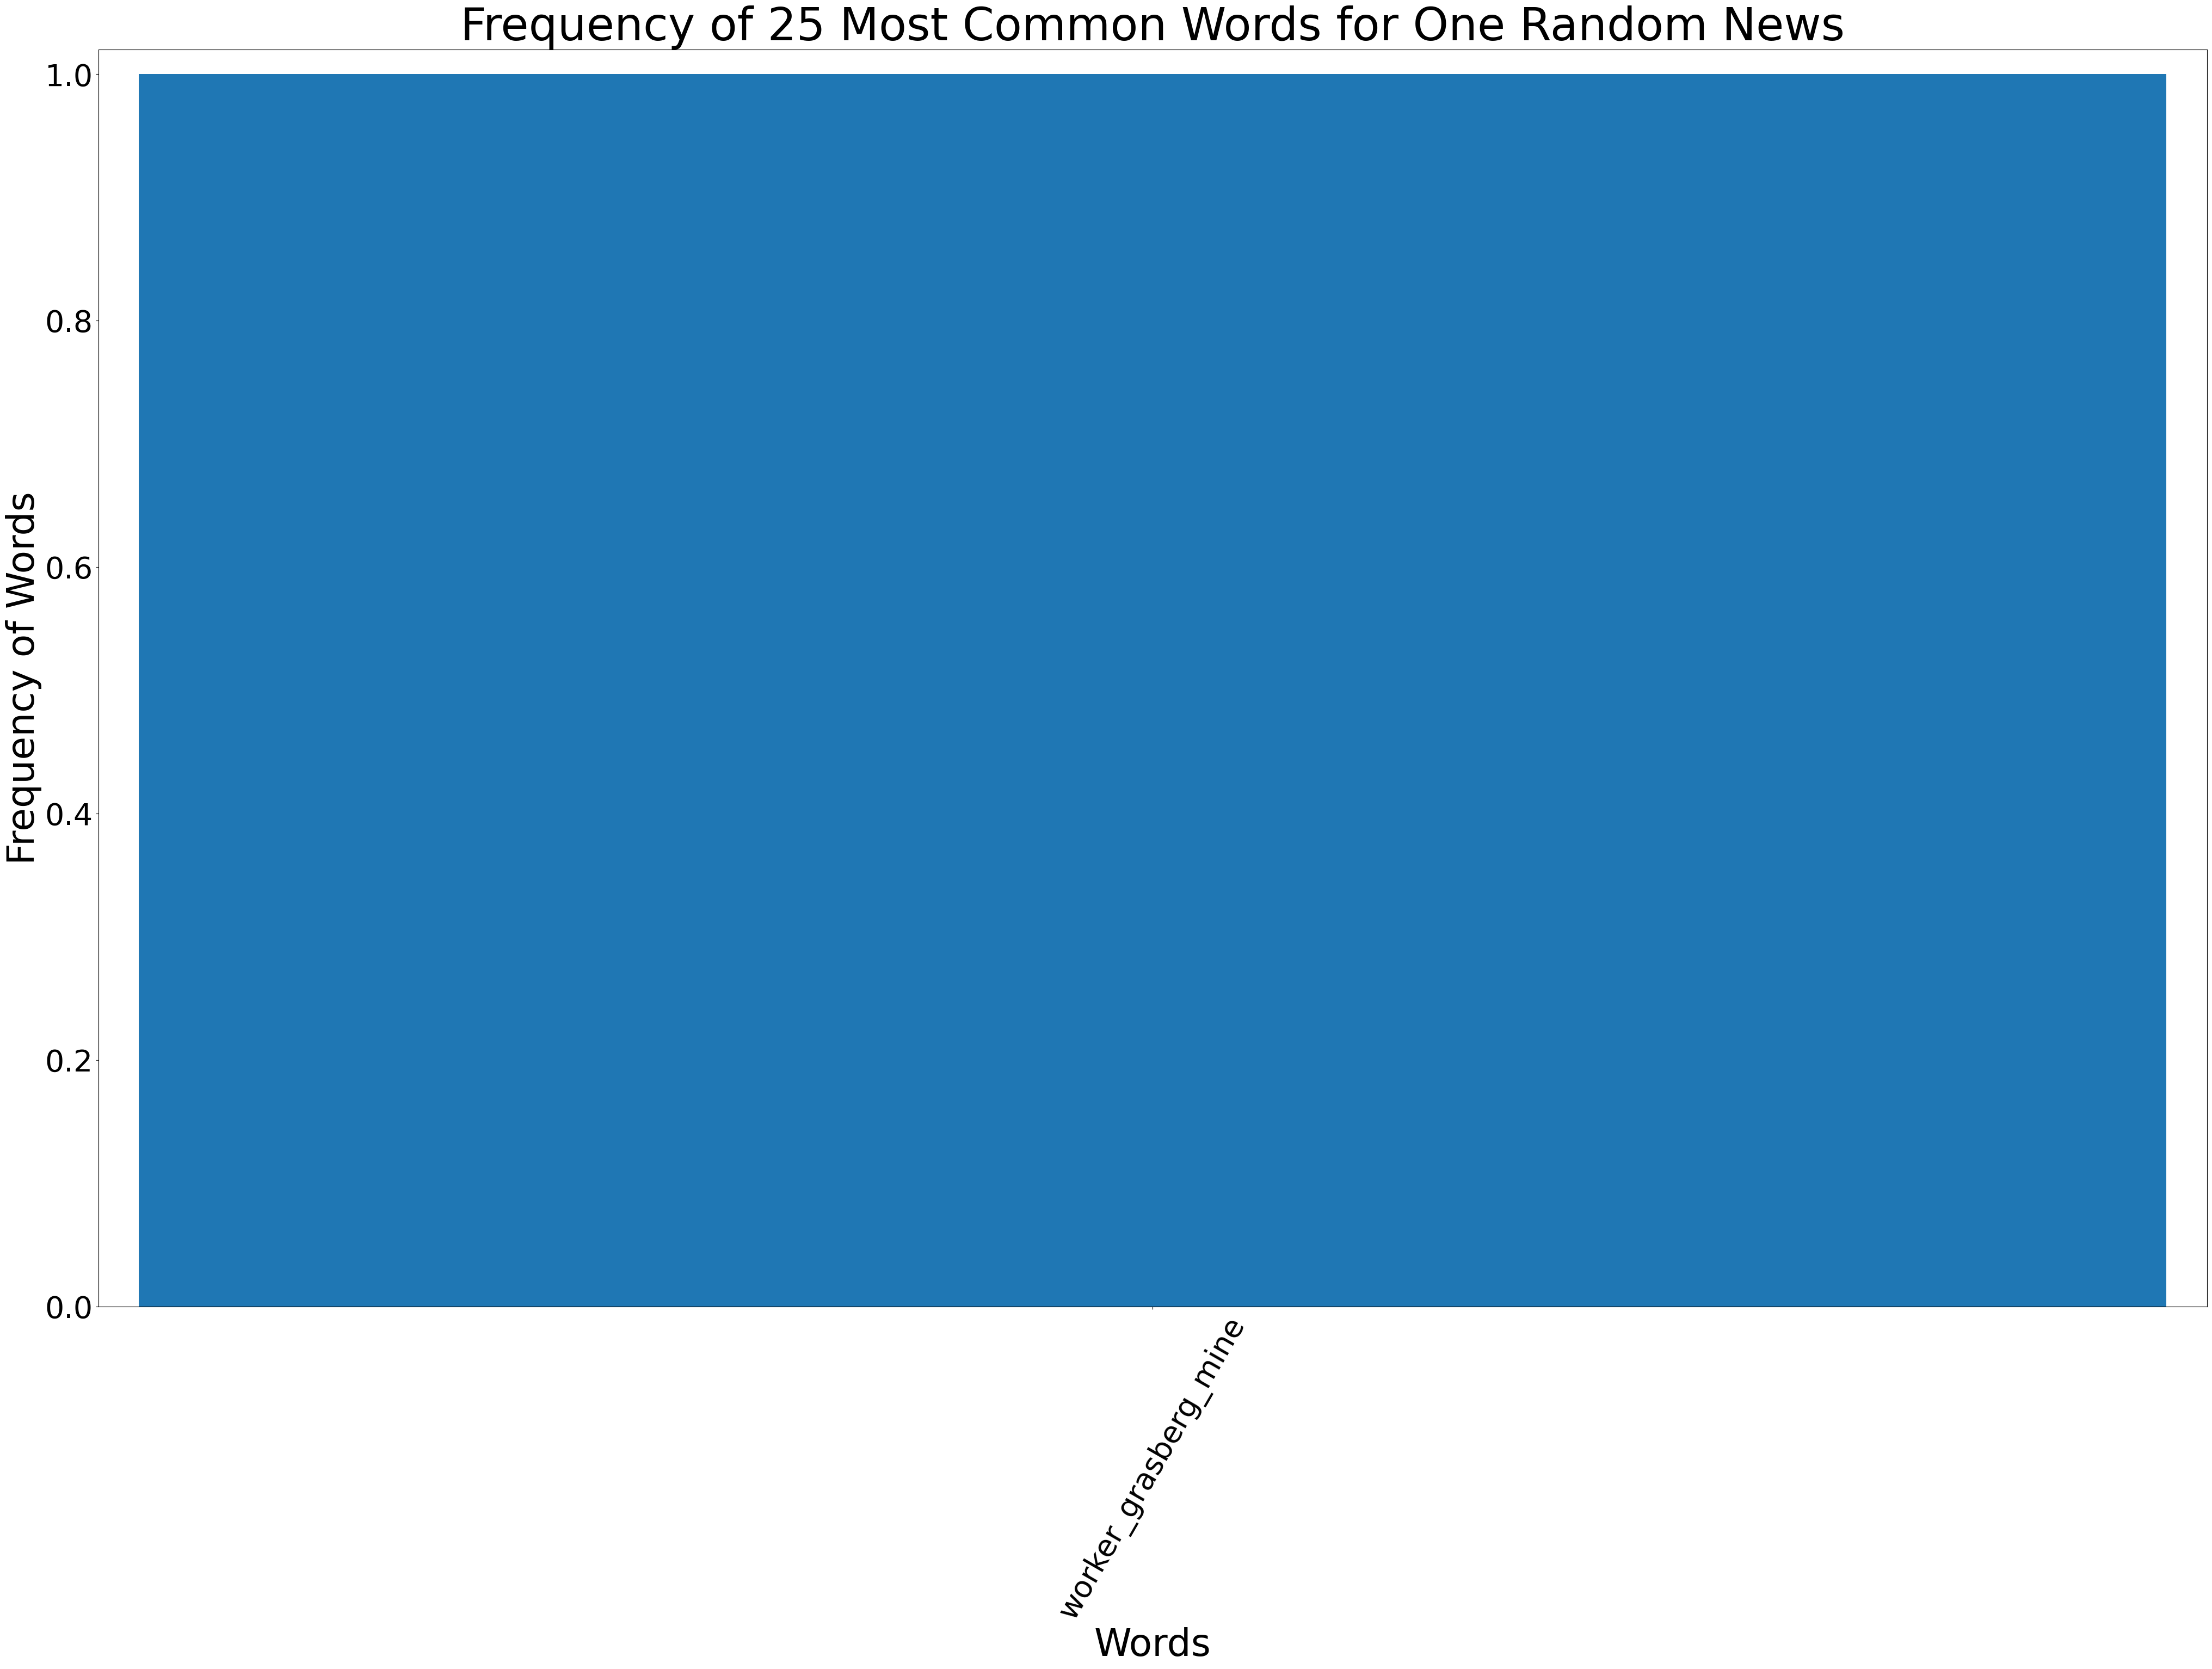

In [32]:
fdist_doc = nltk.FreqDist(df_uni["binary_Headline_Details"][0]).most_common(25)

x, y = zip(*fdist_doc)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel("Words", fontsize=50)
plt.ylabel("Frequency of Words", fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title("Frequency of 25 Most Common Words for One Random News", fontsize=60)
plt.show()

In [33]:
all_words_filtered = [
    word for sublist in df_uni["binary_Headline_Details"] for word in sublist
]
all_words_filtered[:2]
# Calculate word frequencies
fdist_filtered = FreqDist(all_words_filtered)

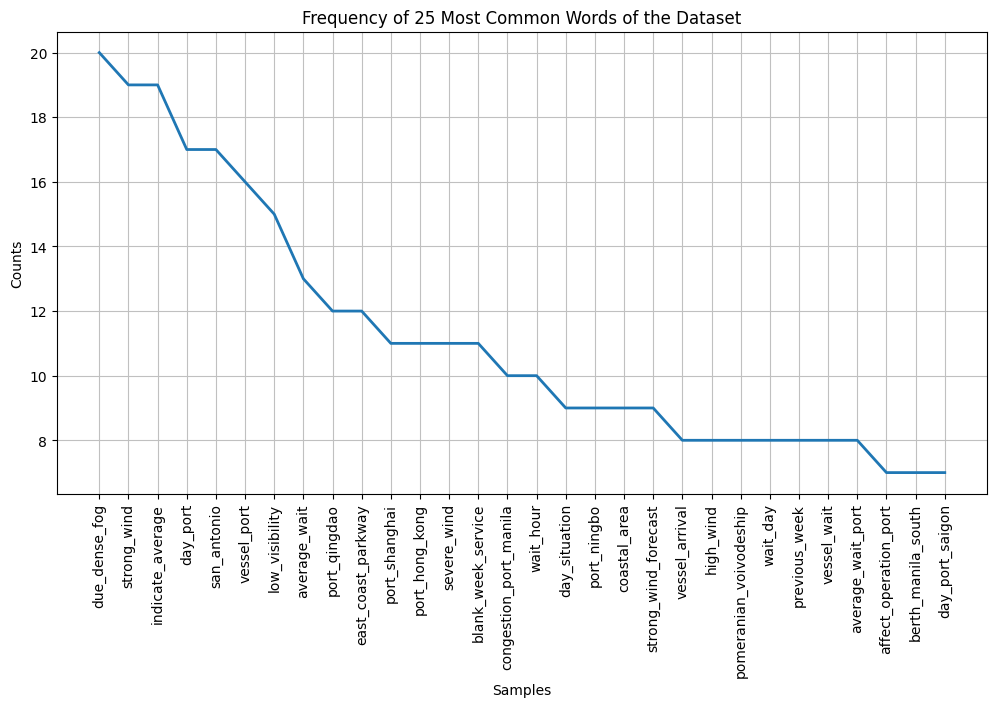

<Axes: title={'center': 'Frequency of 25 Most Common Words of the Dataset'}, xlabel='Samples', ylabel='Counts'>

In [34]:
# Plot the word frequency distribution as a bar graph
# apparently, the dataset is much cleaner now.
plt.figure(figsize=(12, 6))
plt.title("Frequency of 25 Most Common Words of the Dataset", fontsize=12)
fdist_filtered.plot(30, cumulative=False)

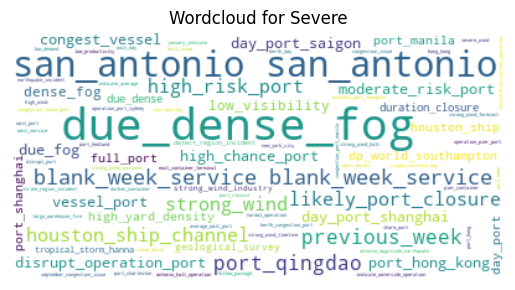

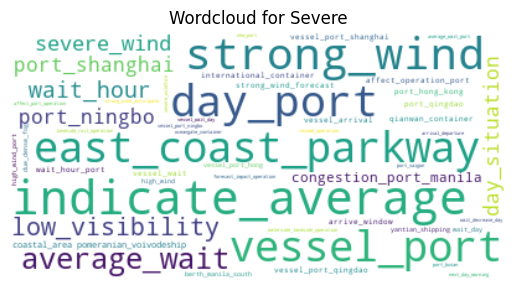

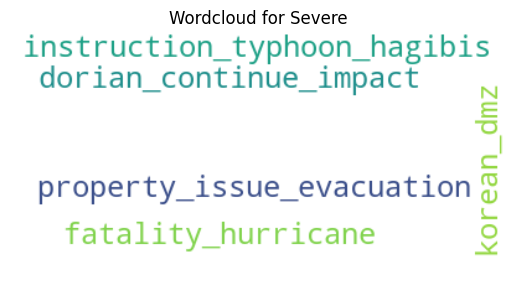

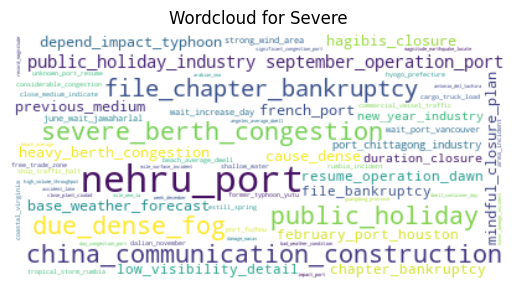

In [35]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Plotting with Seaborn for each company
for region in com[:10]:
    haha = df_uni["binary_Headline_Details"].loc[df_uni.Severity == region]
    text = " ".join(" ".join(item) for item in haha)
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Wordcloud for {company}")
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

In [36]:
df_uni["word_count"] = df_uni["binary_Headline_Details"].apply(len)

In [37]:
df_uni[["word_count"]].describe().round()

word_count
count      5778.0
mean          1.0
std           1.0
min           0.0
25%           0.0
50%           1.0
75%           2.0
max           6.0

In [38]:
# count of news by sector
df_uni[["binary_Headline_Details", "Region"]].groupby("Region").count().sort_values(
    by="binary_Headline_Details", ascending=False
)

binary_Headline_Details
Region                                 
China                               820
United States                       721
Australia                           378
United Kingdom                      346
South Africa                        257
...                                 ...
Libya                                 1
Lithuania                             1
Madagascar                            1
Nepal                                 1
Georgia                               1

[111 rows x 1 columns]

In [39]:
df_uni[["binary_Headline_Details", "Severity"]].groupby("Severity").count().sort_values(
    by="binary_Headline_Details", ascending=False
)

binary_Headline_Details
Severity                         
Moderate                     2840
Minor                        2440
Severe                        488
Extreme                        10

# Save data to database for modelling

In [40]:
df_uni.head()

id                                           Headline  \
0  1.0  Grasberg Mine- Grasberg mine workers extend st...   
1  2.0  Indonesia: Undersea internet cables damaged by...   
2  3.0  Shanghai port congestion impacts terminals in ...   
3  4.0  UPDATE - Indonesia: Explosion at KP Terminal i...   
4  5.0  UPDATE - Indonesia: Police confirm two explosi...   

                                             Details  Severity  \
0  Media sources indicate that workers at the Gra...  Moderate   
1  News sources are stating that recent typhoons ...     Minor   
2  The persisting port congestion at Shanghai’s Y...     Minor   
3  Updated local media sources from Jakarta indic...   Extreme   
4  According to local police in Jakarta, two expl...   Extreme   

                     Category     Region       Datetime    Year       lat  \
0         Mine Workers Strike  Indonesia  28/5/17 17:08  2017.0  -4.05608   
1              Travel Warning  Indonesia   4/9/17 14:30  2017.0       NaN   
2             Port Congestion      China   27/4/17 9:16  2017.0  29.52000   
3  Bombing, Police Operations  Indonesia  24/5/17 15:15  2017.0  -6.22465   
4  Bombing, Police Operations  Indonesia  24/5/17 16:20  2017.0       NaN   

         lon maritime_label                        found_ports  \
0  137.11302          False                       ['freeport']   
1        NaN          False                      ['hong kong']   
2  121.33190           True  ['ningbo', 'qingdao', 'shanghai']   
3  106.86700           True                        ['jakarta']   
4        NaN           True                        ['jakarta']   

   contains_port_info if_labeled  Month  Week  \
0                 1.0      False    5.0  21.0   
1                 1.0      False    4.0  14.0   
2                 1.0      False    4.0  17.0   
3                 1.0      False    5.0  21.0   
4                 1.0       True    5.0  21.0   

                                    Headline_Details  \
0  Grasberg Mine- Grasberg mine workers extend st...   
1  Indonesia: Undersea internet cables damaged by...   
2  Shanghai port congestion impacts terminals in ...   
3  UPDATE - Indonesia: Explosion at KP Terminal i...   
4  UPDATE - Indonesia: Police confirm two explosi...   

                            cleaned_Headline_Details  \
0  [grasberg, grasberg, mine, worker, extend, str...   
1  [indonesia, undersea, internet, cable, damage,...   
2  [shanghai, port, congestion, impact, terminal,...   
3  [update, indonesia, explosion, at, kp, termina...   
4  [update, indonesia, police, confirm, two, expl...   

     binary_Headline_Details  word_count  
0     [worker_grasberg_mine]           1  
1  [undersea_internet_cable]           1  
2                         []           0  
3                         []           0  
4                         []           0

In [41]:
df_uni.columns.to_list()

['id',
 'Headline',
 'Details',
 'Severity',
 'Category',
 'Region',
 'Datetime',
 'Year',
 'lat',
 'lon',
 'maritime_label',
 'found_ports',
 'contains_port_info',
 'if_labeled',
 'Month',
 'Week',
 'Headline_Details',
 'cleaned_Headline_Details',
 'binary_Headline_Details',
 'word_count']

In [42]:
# export as parquet data file instead of csv for easier list extraction
df_uni.to_parquet("data/processed_data.parquet", index=False)